In [1]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

data = pd.read_csv('http://www.creditriskanalytics.net/uploads/1/9/5/1/19511601/hmeq.csv', header = 0, sep = ',')
data.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1100,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,1.0,9.0,NaN
1,1,1300,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.833333,0.0,14.0,NaN
2,1,1500,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466667,1.0,10.0,NaN
3,1,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,1700,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333333,0.0,14.0,NaN


In [ ]:
data.describe()

In [ ]:
# Thống kê các thuộc tính thuộc dạng categorical
data_cat = data.select_dtypes(exclude='number')
data_cat.loc[:, "BAD"] = data.loc[:, "BAD"].astype(str)
data_cat.describe()

In [ ]:
data.info()

In [ ]:
# Vẽ biểu đồ thể hiện sự tương quan giữa các thuộc tính
data_number = data.select_dtypes('number')
plt.figure(figsize=(6, 6))
sns.heatmap(data_number.corr(), square=True, cmap='RdBu_r', annot=True,  fmt='.1f');

In [ ]:
#Vẽ boxplot các thuộc tính dạng numeric
data_number.plot(kind = "box", subplots = True, figsize = (15, 8));
plt.tight_layout()

In [ ]:
# Biểu đồ histogram
def _plot_hist_subplot(x, fieldname, bins = 10, use_kde = True):
  x = x.dropna()
  xlabel = '{} bins tickers'.format(fieldname)
  ylabel = 'Count obs in {} each bin'.format(fieldname)
  title = 'histogram plot of {} with {} bins'.format(fieldname, bins)
  ax = sns.distplot(x, bins = bins, kde = use_kde)
  ax.set_xlabel(xlabel)
  ax.set_ylabel(ylabel)
  ax.set_title(title)
  return ax

# Biểu đồ barchart
def _plot_barchart_subplot(x, fieldname):
  xlabel = 'Group of {}'.format(fieldname)
  ylabel = 'Count obs in {} each bin'.format(fieldname)
  title = 'Barchart plot of {}'.format(fieldname)
  x = x.fillna('Missing')
  df_summary = x.value_counts(dropna = False)
  y_values = df_summary.values
  x_index = df_summary.index
  ax = sns.barplot(x = x_index, y = y_values, order = x_index)
  # Tạo vòng for lấy tọa độ đỉnh trên cùng của biểu đồ và thêm label thông qua annotate.
  labels = list(set(x))
  for label, p in zip(y_values, ax.patches):
    ax.annotate(label, (p.get_x()+0.25, p.get_height()+0.15))
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.title(title)
  return ax

# Khởi tạo figure cho đồ thị (Kích thước W*H = 16x12) và cách nhau là 0.2 giữa các đồ thị
fig = plt.figure(figsize=(18, 16))
fig.subplots_adjust(hspace=0.5, wspace=0.2)
# Tạo vòng for check định dạng của biến và visualize
for i, (fieldname, dtype) in enumerate(zip(data.columns, data.dtypes.values)):
  if i <= 11:
    ax_i = fig.add_subplot(4, 3, i+1)
    if dtype in ['float64', 'int64']:
      ax_i = _plot_hist_subplot(data[fieldname], fieldname=fieldname)
    else:
      ax_i = _plot_barchart_subplot(data[fieldname], fieldname=fieldname)

fig.suptitle('Visualization all fields')
plt.show()

In [8]:
# Xử lý missing data:
# - Đối với các biến định lượng, fill bằng mean
# - Đối với các biến định tính, fill 'Missing'
columns_num = data.select_dtypes(['float', 'int', 'int64']).columns
data[columns_num] = data[columns_num].apply(lambda x: x.fillna(x.mean()), axis=0)

columns_obj = data.select_dtypes(['object']).columns
data[columns_obj] = data[columns_obj].apply(lambda x: x.fillna('Missing'), axis=0)

In [10]:
MAX_VAL = 999999999
MIN_VAL = -MAX_VAL
# MAX_VAL và MIN_VAL là giá trị cực đại và cực tiểu, dùng để điều chỉnh các ngưỡng khi phân khoảng

def _bin_table(data, colname, n_bins = 10, qcut = None):
  """
  Input: dataframe, tên cột cần phân tích, số lượng khoảng (n_bins) và qcut
  Output: bảng tổng hợp số lượng quan sát, số lượng Good, Bad của các khoảng.
  """
  X = data[[colname, 'BAD']]
  X = X.sort_values(colname)
  coltype = X[colname].dtype

  if coltype in ['float', 'int', 'int64']:
    if qcut is None:
      try:
        # Phân chia dữ liệu thành các khoảng bằng pd.qcut (qcut: quantile cut, retbins: return bins)
        bins, thres = pd.qcut(X[colname], q = n_bins, retbins=True)
        # Thay thế threshold đầu và cuối của thres
        thres[0] = MIN_VAL
        thres[-1] = MAX_VAL
        # Do ta đã điều chỉnh 2 đầu mút, ta cần chia lại khoảng (bins)
        # Sử dụng pd.cut để làm việc này, pd.cut cũng tương tự như pd.qcut nhưng đầu vào nhận là các ngưỡng thres đã có chứ không phải số lượng bins
        # Tức là ta chỉ update bins

        bins, thres = pd.cut(X[colname], bins=thres, retbins=True)
        X['bins'] = bins
      except:
        print('n_bins must be lower to bin interval is valid!')
    else:
      # nếu qcut is not None, nghĩa là chúng ta chọn manual các ngưỡng thres
      bins, thres = pd.cut(X[colname], bins=qcut, retbins=True)
      X['bins'] = bins
  elif coltype == 'object':
    X['bins'] = X[colname]

  # Tạo bảng pivot thống kê số lượng mục BAD trong các khoảng
  df_GB = pd.pivot_table(X,
                index = ['bins'],
                values = ['BAD'],
                columns = ['BAD'],
                aggfunc = {
                    'BAD':np.size
                })
  print(df_GB)
  # Đếm số lượng quan sát trong mỗi khoảng
  df_Count = pd.pivot_table(X,
                index = ['bins'],
                values = ['BAD'],
                aggfunc = {
                    'BAD': np.size
                })
  print(df_Count)

  if coltype in ['float', 'int', 'int64']:
    df_Thres = pd.DataFrame({'Thres':thres[1:]}, index=df_GB.index)
  elif coltype == 'object':
    df_Thres = pd.DataFrame(index=df_GB.index)
    thres = None
  df_Count.columns = ['No_Obs']
  df_GB.columns = ['#BAD', '#GOOD']
  df_summary = df_Thres.join(df_Count).join(df_GB)
  return df_summary, thres

In [6]:
def _WOE(data, colname, n_bins = None, min_obs = 100, qcut = None):

  # Thống kê bins và lấy ra thres hold ban đầu dựa vào _bin_table function
  df_summary, thres = _bin_table(data, colname, n_bins = n_bins, qcut = qcut)

  # Thay thế giá trị 0 của #BAD trong df_summary bằng 1 để không bị lỗi chia cho 0 (khi tính GOOD / BAD)
  df_summary['#BAD'] = df_summary['#BAD'].replace({0:1})

  # Nếu đã set trước các ngưỡng phân khoảng, gộp các khoảng (bins) lại để đảm bảo có đủ quan sát tối thiểu tại mỗi khoảng
  if qcut is not None:
    # Lọc bỏ threshold để tạo thành threshold mới mà thỏa mãn số lượng quan sát >= min_obs
    exclude_ind = np.where(df_summary['No_Obs'] <= min_obs)[0]
    if exclude_ind.shape[0] > 0:
      new_thres = np.delete(thres, exclude_ind)
      print('Auto combine {} bins into {} bins'.format(n_bins, new_thres.shape[0]-1))
      # Tính toán lại bảng summary
      df_summary, thres = _bin_table(data, colname, qcut=new_thres)

  new_thres = thres

  # - GOOD/BAD: Tỷ lệ giữa số lượng tốt (`#GOOD`) và xấu (`#BAD`).
  # - %BAD: Tỷ lệ phần trăm các trường hợp xấu so với tổng số các trường hợp xấu.
  # - %GOOD: Tỷ lệ phần trăm các trường hợp tốt so với tổng số các trường hợp tốt.
  # - WOE: Tính toán Weight of Evidence, được tính bằng log của tỷ lệ `%GOOD` chia cho `%BAD`.
  # - IV: Information Value, được tính bằng công thức `(%GOOD - %BAD) * WOE`.

  df_summary['GOOD/BAD'] = df_summary['#GOOD']/df_summary['#BAD']
  df_summary['%BAD'] = df_summary['#BAD']/df_summary['#BAD'].sum()
  df_summary['%GOOD'] = df_summary['#GOOD']/df_summary['#GOOD'].sum()
  df_summary['WOE'] = np.log(df_summary['%GOOD']/df_summary['%BAD'])
  df_summary['IV'] = (df_summary['%GOOD']-df_summary['%BAD'])*df_summary['WOE']
  df_summary['COLUMN'] = colname
  IV = df_summary['IV'].sum()
  print('Information Value of {} column: {}'.format(colname, IV))
  return df_summary, IV, new_thres

In [11]:
# Đối với các biến numeric
WOE_dict=dict()
# Ta chia mặc định mỗi biến thành 10 bins, trong đó có NINQ (số lượng hạn mức tín dụng gần đây) và DEBTINC ( Nợ / Thu nhập) do đặc thù dữ liệu, sẽ được chia thành 2 bins và 7 bins
# Nếu chia quá nhỏ (số bins lớn) thì có thể có những bin trống
nbins = {'LOAN': 10, 'MORTDUE': 10, 'VALUE': 10, 'YOJ':10, 'CLAGE':10, 'NINQ': 2, 'CLNO':10, 'DEBTINC':7}
for (col, bins) in nbins.items():
  df_summary, IV, thres = _WOE(data, colname=col, n_bins=bins)
  print(col, df_summary, thres)
  WOE_dict[col] = {'table':df_summary, 'IV':IV}

                        BAD     
BAD                       0    1
bins                            
(-999999999.0, 7600.0]  374  229
(7600.0, 10000.0]       471  137
(10000.0, 12100.0]      476  106
(12100.0, 14400.0]      503  107
(14400.0, 16300.0]      447  131
(16300.0, 18800.0]      520   84
(18800.0, 21700.0]      492   99
(21700.0, 25000.0]      506  107
(25000.0, 30500.0]      504   72
(30500.0, 999999999.0]  478  117
                        BAD
bins                       
(-999999999.0, 7600.0]  603
(7600.0, 10000.0]       608
(10000.0, 12100.0]      582
(12100.0, 14400.0]      610
(14400.0, 16300.0]      578
(16300.0, 18800.0]      604
(18800.0, 21700.0]      591
(21700.0, 25000.0]      613
(25000.0, 30500.0]      576
(30500.0, 999999999.0]  595
Information Value of LOAN column: 0.1601563338988017
LOAN                               Thres  No_Obs  #BAD  #GOOD  GOOD/BAD      %BAD  \
bins                                                                           
(-999999999.0, 76

In [12]:
#Do các biến
#   - DEROG (Số lượng báo cáo thông tin tín dụng xấu nghiêm trọng),
#   - DELINQ (Số lần thất bại chi trả nợ cho hạn mức tín dụng)
# có xu hướng là biến thứ bậc hơn là biến liên tục nên áp dụng cách phân chia theo quantile sẽ tạo ra những khoảng bins có độ dài bằng 0. Do đó chúng ta sẽ phân chia theo ngưỡng cutpoint.
# Ngưỡng cutpoint được lựa chọn là 1, mang ý nghĩa đã vi phạm tín dụng hay chưa

for col in ['DEROG', 'DELINQ']:
  df_summary, IV, thres = _WOE(data, colname=col, n_bins=5, qcut=[MIN_VAL, 1, MAX_VAL])
  WOE_dict[col] = {'table':df_summary, 'IV':IV}

                  BAD      
BAD                 0     1
bins                       
(-999999999, 1]  4660  1010
(1, 999999999]    111   179
                  BAD
bins                 
(-999999999, 1]  5670
(1, 999999999]    290
Information Value of DEROG column: 0.25544310740061354
                  BAD     
BAD                 0    1
bins                      
(-999999999, 1]  4536  877
(1, 999999999]    235  312
                  BAD
bins                 
(-999999999, 1]  5413
(1, 999999999]    547
Information Value of DELINQ column: 0.41067752435125704


In [13]:
#Tiếp theo ta sẽ tính toán IV cho các biến category là REASON và JOB.
for col in ['REASON', 'JOB']:
  df_summary, IV, thres = _WOE(data, colname=col)
  WOE_dict[col] = {'table':df_summary, 'IV':IV}

          BAD     
BAD         0    1
bins              
DebtCon  3183  745
HomeImp  1384  396
Missing   204   48
          BAD
bins         
DebtCon  3928
HomeImp  1780
Missing   252
Information Value of REASON column: 0.008618460238864025
          BAD     
BAD         0    1
bins              
Mgr       588  179
Missing   256   23
Office    823  125
Other    1834  554
ProfExe  1064  212
Sales      71   38
Self      135   58
          BAD
bins         
Mgr       767
Missing   279
Office    948
Other    2388
ProfExe  1276
Sales     109
Self      193
Information Value of JOB column: 0.1237305657142077


In [15]:
columns = []
IVs = []
for col in data.columns:
  if col != 'BAD':
    columns.append(col)
    IVs.append(WOE_dict[col]['IV'])
df_WOE = pd.DataFrame({'column': columns, 'IV': IVs})

def _rank_IV(iv):
  if iv <= 0.02:
    return 'Useless'
  elif iv <= 0.1:
    return 'Weak'
  elif iv <= 0.3:
    return 'Medium'
  elif iv <= 0.5:
    return 'Strong'
  else:
    return 'suspicious'

df_WOE['rank']=df_WOE['IV'].apply(lambda x: _rank_IV(x))
df_WOE.sort_values('IV', ascending=False)

,column,IV,rank
11,DEBTINC,1.379557,suspicious
7,DELINQ,0.410678,Strong
6,DEROG,0.255443,Medium
8,CLAGE,0.221710,Medium
0,LOAN,0.160156,Medium
2,VALUE,0.141889,Medium
4,JOB,0.123731,Medium
9,NINQ,0.069659,Weak
5,YOJ,0.067147,Weak
10,CLNO,0.060437,Weak


In [16]:
for col in WOE_dict.keys():
  try:
    key = list(WOE_dict[col]['table']['WOE'].index)
    woe = list(WOE_dict[col]['table']['WOE'])
    d = dict(zip(key, woe))
    col_woe = col+'_WOE'
    data[col_woe] = data[col].map(d)
  except:
    print(col)

print(data)



      BAD   LOAN     MORTDUE          VALUE   REASON      JOB        YOJ  \
0       1   1100  25860.0000   39025.000000  HomeImp    Other  10.500000   
1       1   1300  70053.0000   68400.000000  HomeImp    Other   7.000000   
2       1   1500  13500.0000   16700.000000  HomeImp    Other   4.000000   
3       1   1500  73760.8172  101776.048741  Missing  Missing   8.922268   
4       0   1700  97800.0000  112000.000000  HomeImp   Office   3.000000   
...   ...    ...         ...            ...      ...      ...        ...   
5955    0  88900  57264.0000   90185.000000  DebtCon    Other  16.000000   
5956    0  89000  54576.0000   92937.000000  DebtCon    Other  16.000000   
5957    0  89200  54045.0000   92924.000000  DebtCon    Other  15.000000   
5958    0  89800  50370.0000   91861.000000  DebtCon    Other  14.000000   
5959    0  89900  48811.0000   88934.000000  DebtCon    Other  15.000000   

        DEROG    DELINQ       CLAGE  ...  VALUE_WOE   YOJ_WOE  CLAGE_WOE  \
0     0.000

In [17]:
X = data.filter(like='_WOE', axis = 1)
y = data['BAD']

print(X)
print(y)

      LOAN_WOE  MORTDUE_WOE  VALUE_WOE   YOJ_WOE  CLAGE_WOE  NINQ_WOE  \
0     0.898910     0.403995   0.630114  0.094209   0.386975 -0.210721   
1     0.898910    -0.025653  -0.224027 -0.129023   0.288596 -0.210721   
2     0.898910     0.403995   0.630114  0.288849   0.302004 -0.210721   
3     0.898910    -0.356854   0.559662 -0.027355   0.032257  0.332504   
4     0.898910    -0.096285   0.559662  0.288849   0.386975 -0.210721   
...        ...          ...        ...       ...        ...       ...   
5955 -0.017993     0.001050  -0.527866  0.060778  -0.311344 -0.210721   
5956 -0.017993     0.001050  -0.527866  0.060778  -0.431992 -0.210721   
5957 -0.017993     0.001050  -0.527866  0.060778  -0.311344 -0.210721   
5958 -0.017993    -0.063186  -0.527866  0.094209  -0.311344 -0.210721   
5959 -0.017993    -0.063186  -0.080322  0.060778  -0.311344 -0.210721   

      CLNO_WOE  DEBTINC_WOE  DEROG_WOE  DELINQ_WOE  REASON_WOE   JOB_WOE  
0     0.484269     1.359046  -0.139622   -0.2538

In [18]:
from sklearn.model_selection import train_test_split

ids = np.arange(X.shape[0])
X_train, X_test, y_train, y_test, id_train, id_test = train_test_split(X, y, ids, test_size = 0.2, stratify = y, shuffle = True, random_state = 123)


print('X_train shape: ', X_train.shape)
print('X_test shape: ', X_test.shape)
print('y_train shape: ', y_train.shape)
print('y_test shape: ', y_test.shape)

X_train shape:  (4768, 12)
X_test shape:  (1192, 12)
y_train shape:  (4768,)
y_test shape:  (1192,)


In [19]:
from sklearn.linear_model import LogisticRegression
logit_model = LogisticRegression(solver = 'lbfgs', max_iter=1000, fit_intercept=True, tol=0.0001, C=1, penalty='l2')
#tot((tolarance)) là giá trị để dừng cập nhật gradient descent nếu khoảng thay đổi của hàm mất mát sau một bước huấn luyện nhỏ hơn tot.
#max_iter: Số lượt huấn luyện tối đa
#solver là phương pháp để giải bài toán tối ưu đối với cross entropy. ở đây ta dùng phương pháp Limited-memory BFGS(lbfgs)
#C: Hệ số nhân của thành phần penalty.
logit_model.fit(X_train, y_train)

LogisticRegression(C=1, max_iter=1000)

In [20]:
from sklearn.metrics import accuracy_score

y_pred_test = logit_model.predict(X_test)
acc_test = accuracy_score(y_pred_test, y_test)

print('accuracy on test: ', acc_test)

accuracy on test:  0.8624161073825504


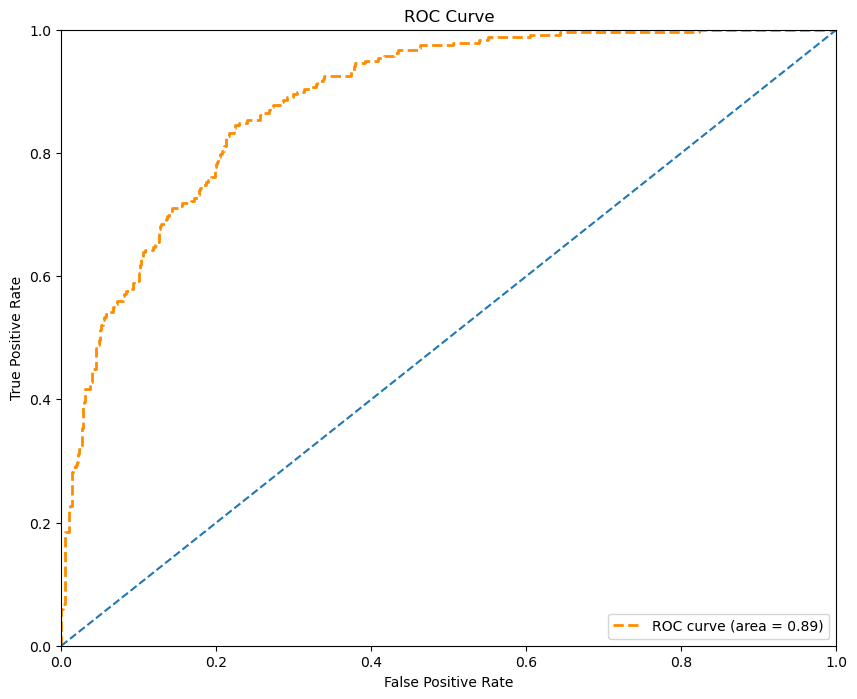

In [21]:
from sklearn.metrics import roc_curve, auc

y_pred_prob_test = logit_model.predict_proba(X_test)[:, 1]
fpr, tpr, thres = roc_curve(y_test, y_pred_prob_test)
roc_auc = auc(fpr, tpr)

def _plot_roc_curve(fpr, tpr, thres, auc):
    plt.figure(figsize = (10, 8))
    plt.plot(fpr, tpr, 'b-', color='darkorange', lw=2, linestyle='--', label='ROC curve (area = %0.2f)'%auc)
    plt.plot([0, 1], [0, 1], '--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.title('ROC Curve')

_plot_roc_curve(fpr, tpr, thres, roc_auc)

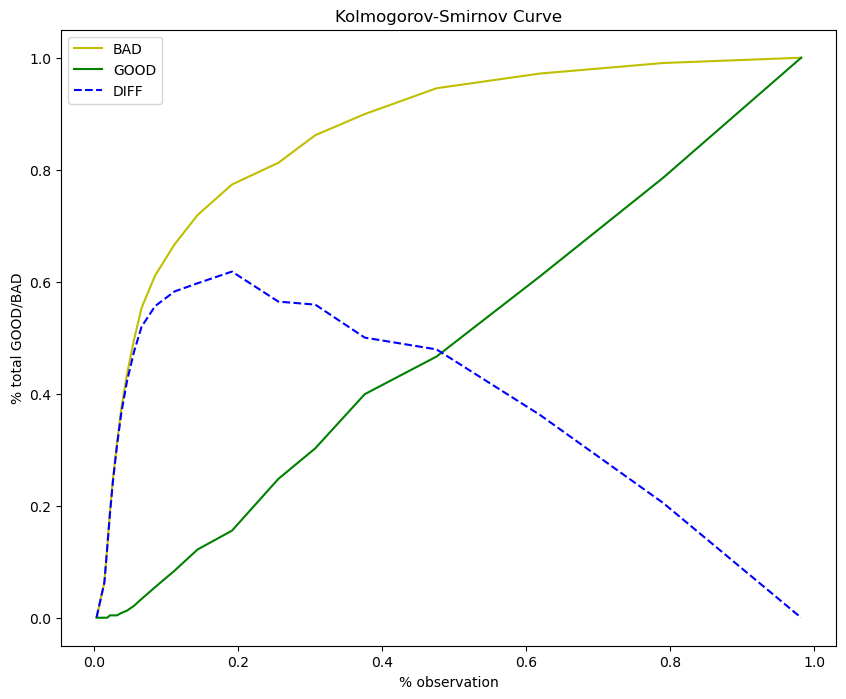

In [22]:
#Tính toán phân phối xác suất tích lũy của GOOD và BAD
def _KM(y_pred, n_bins):
  _, thresholds = pd.qcut(y_pred, q=n_bins, retbins=True)
  cmd_BAD = []
  cmd_GOOD = []
  BAD_id = set(np.where(y_test == 0)[0])
  GOOD_id = set(np.where(y_test == 1)[0])
  total_BAD = len(BAD_id)
  total_GOOD = len(GOOD_id)
  for thres in thresholds:
    pred_id = set(np.where(y_pred <= thres)[0])
    # Đếm % số lượng hồ sơ BAD có xác suất dự báo nhỏ hơn hoặc bằng thres
    per_BAD = len(pred_id.intersection(BAD_id))/total_BAD
    cmd_BAD.append(per_BAD)
    # Đếm % số lượng hồ sơ GOOD có xác suất dự báo nhỏ hơn hoặc bằng thres
    per_GOOD = len(pred_id.intersection(GOOD_id))/total_GOOD
    cmd_GOOD.append(per_GOOD)
  cmd_BAD = np.array(cmd_BAD)
  cmd_GOOD = np.array(cmd_GOOD)
  return cmd_BAD, cmd_GOOD, thresholds

y_pred_prob_test = logit_model.predict_proba(X_test)[:, 1]
cmd_BAD, cmd_GOOD, thresholds = _KM(y_pred_prob_test, n_bins=20)

#Biểu đồ phân phối xác suất tích lũy của GOOD và BAD
def _plot_KM(cmd_BAD, cmd_GOOD, thresholds):
  plt.figure(figsize = (10, 8))
  plt.plot(thresholds, cmd_BAD, 'y-', label = 'BAD')
  plt.plot(thresholds, cmd_GOOD, 'g-', label = 'GOOD')
  plt.plot(thresholds, cmd_BAD-cmd_GOOD, 'b--', label = 'DIFF')
  plt.xlabel('% observation')
  plt.ylabel('% total GOOD/BAD')
  plt.title('Kolmogorov-Smirnov Curve')
  plt.legend()

_plot_KM(cmd_BAD, cmd_GOOD, thresholds)

In [23]:
from scipy import stats

stats.ks_2samp(cmd_BAD, cmd_GOOD)

KstestResult(statistic=0.5238095238095238, pvalue=0.005467427576534314, statistic_location=0.12184873949579832, statistic_sign=-1)

In [31]:
import numpy as np

def _CreditScore(beta, alpha, woe, n = 12, odds = 1/4, pdo = -50, thres_score = 600):
  factor = pdo/np.log(2)
  offset = thres_score - factor*np.log(odds)
  score = (beta*woe+alpha/n)*factor+offset/n
  return score

In [29]:
betas_dict = dict(zip(list(X_train.columns), logit_model.coef_[0]))
alpha = logit_model.intercept_[0]
betas_dict

{'LOAN_WOE': 0.505048138162099,
 'MORTDUE_WOE': 0.5745938026854506,
 'VALUE_WOE': 0.7095331987754482,
 'YOJ_WOE': 0.7387937546292924,
 'CLAGE_WOE': 0.8258098551948865,
 'NINQ_WOE': 0.5137447298213232,
 'CLNO_WOE': 0.890739547649659,
 'DEBTINC_WOE': 0.9312436761616807,
 'DEROG_WOE': 0.814544657618797,
 'DELINQ_WOE': 0.9133973411366914,
 'REASON_WOE': 0.4877975052040271,
 'JOB_WOE': 0.8480476812106958}

In [30]:
cols = []
features = []
woes = []
betas = []
scores = []

for col in columns:
  for feature, woe in WOE_dict[col]['table']['WOE'].to_frame().iterrows():
      cols.append(col)
      # Add feature
      feature = str(feature)
      features.append(feature)
      # Add woe
      woe = woe.values[0]
      woes.append(woe)
      # Add beta
      col_woe = col+'_WOE'
      beta = betas_dict[col_woe]
      betas.append(beta)
      # Add score
      score = _CreditScore(beta = beta, alpha = alpha, woe = woe, n = 12)
      scores.append(score)

df_WOE = pd.DataFrame({'Columns': cols, 'Features': features, 'WOE': woes, 'Betas':betas, 'Scores':scores})
df_WOE.head()
#lưu file điểm phục vụ tín hđiểm tín nhiệm cho KH
df_WOE.to_csv('Sccore.csv')

In [27]:
#save dict WOE_dct
import pickle

with open('myfile.txt', 'wb') as handle:
    pickle.dump(WOE_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)